# Title:  
**Multi-Asset Portfolio Analysis and Optimization Using 10 Years of ETF Data**

---

## Notebook Summary

This notebook provides a comprehensive workflow for analyzing, visualizing, and optimizing a diversified portfolio of global ETFs over the past 10 years. It covers data acquisition, return and risk analysis, factor regressions, and portfolio optimization under realistic investment constraints.

---

## Outline

### 1. **Introduction & Setup**
- Overview of the notebook's purpose and workflow.
- Automated installation and import of required Python libraries.

### 2. **Portfolio Details & Data Acquisition**
- Parsing portfolio tickers, risk-free rate, and investment constraints from a configuration file.
- Downloading 10 years of weekly price data for selected ETFs using `yfinance`.
- Saving and displaying the cleaned dataset.

### 3. **Data Visualization**
- Interactive line chart of ETF prices over time (Plotly).
- Calculation and plotting of cumulative simple and log returns (Plotly).

### 4. **Return & Risk Analysis**
- Calculation of weekly simple and log returns.
- Descriptive statistics: annualized mean, volatility, skewness, kurtosis, max/min returns, Sharpe ratio.
- Grouped bar chart of descriptive statistics (Plotly).
- Correlation heatmap of ETF returns (Seaborn).

### 5. **Downside & Tail Risk Metrics**
- Value at Risk (VaR) and Conditional VaR (CVaR) at 5% level.
- Maximum drawdown for each asset.
- Beta vs. US stocks.
- GARCH model-based volatility estimation.
- Grouped bar chart of risk metrics (Plotly).

### 6. **Factor Regression Analysis**
- Calculation of monthly returns.
- Integration of Fama-French and momentum factors.
- CAPM and multi-factor regressions for each asset.
- Bar charts comparing CAPM beta, alpha, and multi-factor model R² (Matplotlib).

### 7. **Portfolio Optimization**
- Monte Carlo simulation of 30,000 portfolios under investment constraints.
- Identification of the optimal (max Sharpe) and minimum volatility portfolios.
- Efficient frontier plot with Sharpe ratio color mapping and optimal portfolio highlight (Matplotlib).
- Capital Market Line (CML) overlay.
- Bar chart of optimal portfolio weights.

### 8. **Results & Export**
- Display and export of optimal and minimum volatility portfolio allocations.
- Summary statistics for both portfolios.

---

## Key Charts & Visualizations

- **Interactive ETF Price Chart** (Plotly)
- **Cumulative Returns (Simple & Log)** (Plotly)
- **Descriptive Statistics Bar Chart** (Plotly)
- **Correlation Heatmap** (Seaborn)
- **Downside & Tail Risk Bar Chart** (Plotly)
- **Factor Regression Bar Charts** (Matplotlib)
- **Efficient Frontier & Capital Market Line** (Matplotlib)
- **Optimal Portfolio Weights Bar Chart** (Matplotlib)

---

This workflow enables robust portfolio analysis, risk assessment, and evidence-based asset allocation for diversified ETF portfolios.

In [2]:
# -*- coding: utf-8 -*-
"""
This notebook downloads 10 years of weekly market data for various ETFs using yfinance.
It retrieves data for US stocks, US bonds, developed market stocks (excluding the US),
developed market bonds (excluding the US), emerging market stocks, emerging market bonds, and gold.
The data is saved to a CSV file named 'weekly_market_data_20yr.csv'.
"""

import sys
import subprocess
import os

# Check and install required libraries
required_libraries = [
    "yfinance", "pandas", "pandas_datareader", "tabulate", "matplotlib",
    "numpy", "seaborn", "arch", "plotly", "statsmodels", "pandas_datareader"
]
missing_libraries = []

for lib in required_libraries:
    try:
        __import__(lib)
    except ImportError:
        missing_libraries.append(lib)

if missing_libraries:
    print(f"Missing libraries: {', '.join(missing_libraries)}. Installing...")
    for lib in missing_libraries:
        subprocess.check_call([sys.executable, "-m", "pip", "install", lib])
else:
    print("All required libraries are installed.")

import yfinance as yf
import pandas as pd
import pandas_datareader.data as web
from datetime import datetime, timedelta
from tabulate import tabulate
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from arch import arch_model
import plotly.graph_objs as go
import plotly.offline as pyo
import statsmodels.api as sm

All required libraries are installed.


In [3]:
# Read file
with open("port_details.txt", "r") as file:
    lines = file.readlines()

tickers = {}
constraints = {}
risk_free_rate = None

# Parse content
section = None
for line in lines:
    line = line.strip()
    if not line:
        continue  # skip empty lines
    elif line.endswith(":") and line.count(":") == 1:
        section = line[:-1]
    elif section == "Tickers":
        key, value = line.split(": ")
        tickers[key.strip()] = value.strip()
    elif section == "Risk-free Rate":
        risk_free_rate = float(line.strip())
    elif section == "Investment Constraints":
        if "<=" in line:
            key, value = line.split(" <= ")
            constraints[key.strip()] = {"type": "max", "value": float(value.strip().strip("%")) / 100}
        elif ">=" in line:
            key, value = line.split(" >= ")
            constraints[key.strip()] = {"type": "min", "value": float(value.strip().strip("%")) / 100}
        elif ">" in line:
            key, value = line.split(" > ")
            constraints[key.strip()] = {"type": "min", "value": float(value.strip().strip("%")) / 100}
        elif "<" in line:
            key, value = line.split(" < ")
            constraints[key.strip()] = {"type": "max", "value": float(value.strip().strip("%")) / 100}

# Define 10-year date range
end_date = end_date = datetime(2025, 6, 13)
start_date = end_date - timedelta(weeks=52 * 10)

# Download weekly close data
data = yf.download(
    tickers=list(tickers.values()),
    start=start_date.strftime('%Y-%m-%d'),
    end=end_date.strftime('%Y-%m-%d'),
    interval="1wk",
    auto_adjust=False,
    back_adjust=False
    )["Close"]

# Rename columns in alphabetical order of tickers
ticker_to_asset = {v: k for k, v in tickers.items()}
data = data.rename(columns=ticker_to_asset)
priority = ['US_Stocks', 'US_Bonds', 'Dev_Stocks_ExUS', 'Dev_Bonds_ExUS',
            'EM_Stocks', 'EM_Bonds', 'Cash']
rest = [col for col in data.columns if col not in priority]
data = data[priority + rest]


# Save to CSV
os.makedirs("exports", exist_ok=True)
data.to_csv("exports/weekly_market_data_10yr_combined.csv") 
print("Saved as 'weekly_market_data_10yr_combined.csv' in exports directory.")
print("\nData Columns:")
print(", ".join(data.columns))

# Output results
print("\nParsed Portfolio Details:")
print("Tickers:", tickers)
print("Risk-Free Rate:", risk_free_rate)
print("Constraints:", constraints)

[*********************100%***********************]  7 of 7 completed


Saved as 'weekly_market_data_10yr_combined.csv' in exports directory.

Data Columns:
US_Stocks, US_Bonds, Dev_Stocks_ExUS, Dev_Bonds_ExUS, EM_Stocks, EM_Bonds, Cash

Parsed Portfolio Details:
Tickers: {'US_Stocks': 'VOO', 'US_Bonds': 'AGG', 'Dev_Stocks_ExUS': 'SCHF', 'Dev_Bonds_ExUS': 'BNDX', 'EM_Stocks': 'VWO', 'EM_Bonds': 'EMB', 'Cash': 'BIL'}
Risk-Free Rate: 0.0441
Constraints: {'Cash:': {'type': 'min', 'value': 0.05}, 'EM_Bonds:': {'type': 'max', 'value': 0.15}, 'EM_Stocks:': {'type': 'max', 'value': 0.15}, 'US_Stocks:': {'type': 'min', 'value': 0.1}, 'US_Bonds:': {'type': 'max', 'value': 0.5}, 'Dev_Stocks_ExUS:': {'type': 'max', 'value': 0.4}, 'Dev_Bonds_ExUS:': {'type': 'max', 'value': 0.4}}


### Data Acquisition, Parsing, and Setup

The code block above is responsible for **setting up the environment, parsing portfolio configuration, and downloading ETF price data** for further analysis. Here’s a breakdown of its workflow:

---

#### 1. **Environment Setup**
- **Library Installation:**  
    Checks for required Python libraries (e.g., `yfinance`, `pandas`, `matplotlib`, `numpy`, `seaborn`, `arch`, `plotly`, `statsmodels`).  
    If any are missing, it installs them automatically.

#### 2. **Imports**
- Imports all necessary modules for data handling, visualization, statistical analysis, and optimization.

#### 3. **Portfolio Configuration Parsing**
- **Reads `port_details.txt`:**  
    Parses the file to extract:
    - **Tickers:** Asset class names mapped to ETF tickers.
    - **Risk-Free Rate:** Used for Sharpe ratio and optimization.
    - **Investment Constraints:** Minimum/maximum allocation rules for each asset.

#### 4. **Data Download**
- **Date Range:**  
    Sets a 10-year window ending at a specified `end_date`.
- **ETF Price Data:**  
    Downloads weekly close prices for all specified ETFs using `yfinance`.
- **Data Cleaning:**  
    Renames columns to asset class names, orders them for consistency, and saves the cleaned data to a CSV file.

#### 5. **Output**
- Prints the parsed tickers, risk-free rate, and constraints for verification.
- Displays the columns of the downloaded data.

---

**Purpose:**  
This setup ensures that all subsequent analysis (returns, risk, optimization) is based on a clean, well-structured dataset, with portfolio rules and constraints clearly defined and enforced from the start.

In [4]:
# Create interactive line chart for ETF prices
fig = go.Figure()
for col in data.columns:
    fig.add_trace(go.Scatter(x=data.index, y=data[col], mode='lines', name=col))

fig.update_layout(
    title='10-Year Weekly Prices of ETFs (Interactive)',
    xaxis_title='Date',
    yaxis_title='Price',
    legend_title='Asset Class',
    template='plotly_white',
    hovermode='x unified',
    width=1000,
    height=600
)
pyo.iplot(fig)


# Calculate simple weekly returns
# Drop the first row to avoid NaN values in returns calculation
simple_returns = data.pct_change().dropna()

# Cumulative returns from normalized starting point (100)
cumulative_returns = (1 + simple_returns).cumprod() * 100

fig = go.Figure()

for col in cumulative_returns.columns:
    fig.add_trace(go.Scatter(x=cumulative_returns.index, y=cumulative_returns[col], mode='lines', name=col))

fig.update_layout(
    title=f'Cumulative Returns of {col} (Base = 100)',
    xaxis_title='Date',
    yaxis_title='Cumulative Value',
    template='plotly_white',
    hovermode='x unified',
    width=1000,
    height=600
)

pyo.iplot(fig)

# Calculate log weekly returns
# Drop the first row to avoid NaN values in returns calculation
log_returns = np.log(data / data.shift(1)).dropna()

# Cumulative returns from normalized starting point (100) using log returns
# Note: Cumulative returns from log returns are calculated differently 
cum_log_returns = np.exp(log_returns.cumsum()) * 100

# Create a new plotly figure for cumulative log returns
fig_log = go.Figure()

for col in cum_log_returns.columns:
    fig_log.add_trace(go.Scatter(x=cum_log_returns.index, y=cum_log_returns[col], mode='lines', name=col))

fig_log.update_layout(
    title='Cumulative Log Returns of Assets (Base = 100)',
    xaxis_title='Date',
    yaxis_title='Cumulative Log Value',
    template='plotly_white',
    hovermode='x unified',
    width=1000,
    height=600
)

pyo.iplot(fig_log)

### Cumulative Returns Charts: Interpretation & Portfolio Relevance

---

#### **1. Cumulative Simple Returns Chart**

- **What it shows:**  
    This interactive line chart visualizes the growth of $100 invested in each ETF over the past 10 years, using simple (percentage) weekly returns.
- **Interpretation:**  
    - **Steeper lines** indicate higher total returns over the period.
    - **Flatter or declining lines** reflect lower or negative performance.
    - **Comparing assets:** You can visually assess which asset classes outperformed or underperformed.
- **Portfolio Relevance:**  
    - Helps identify long-term winners and laggards.
    - Informs initial asset selection and allocation by highlighting historical growth trends.

---

#### **2. Cumulative Log Returns Chart**

- **What it shows:**  
    This chart displays the cumulative log returns for each ETF, again starting from a normalized base of 100.
- **Interpretation:**  
    - **Log returns** are additive over time and better suited for statistical modeling and risk analysis.
    - The shape and spread of the lines provide insight into compounding effects and volatility.
- **Portfolio Relevance:**  
    - Useful for risk modeling and optimization, as log returns are often assumed in quantitative finance.
    - Highlights the impact of volatility and compounding on long-term wealth.

---

### **Summary & Connection to Portfolio Creation**

- **Both charts** provide a visual foundation for understanding the historical performance and risk characteristics of each asset.
- **Cumulative simple returns** guide intuition about absolute growth, while **cumulative log returns** support quantitative modeling.
- These insights are critical for:
    - **Asset selection:** Choosing which ETFs to include.
    - **Weighting decisions:** Allocating more to consistently strong performers or diversifying to manage risk.
    - **Risk assessment:** Understanding drawdowns and volatility before optimization.
- **In the portfolio creation process,** these charts ensure that allocation decisions are data-driven, balancing return potential with risk exposure.

In [5]:
# Descriptive statistics for ETF weekly return series
assets =  data.columns

desc_stats = pd.DataFrame(index=assets)

# Mean (expected return, annualized)
desc_stats['Mean (Ann.)'] = simple_returns.mean() * 52

# Standard deviation (volatility, annualized)
desc_stats['Std Dev (Ann.)'] = simple_returns.std() * np.sqrt(52)

# Skewness (asymmetry)
desc_stats['Skewness'] = simple_returns.skew()

# Kurtosis (fat tails)
desc_stats['Kurtosis'] = simple_returns.kurtosis()

# Max/min weekly returns
desc_stats['Max Return'] = simple_returns.max()
desc_stats['Min Return'] = simple_returns.min()

# Sharpe Ratio (annualized)
desc_stats['Sharpe Ratio'] = (simple_returns.mean() * 52 - risk_free_rate) / (simple_returns.std() * np.sqrt(52))

print("Descriptive Statistics for ETF Weekly Returns (Annualized where appropriate):")
display(desc_stats.round(4))

# Select relevant columns for visualization
stats_plot = desc_stats[['Mean (Ann.)', 'Std Dev (Ann.)', 'Skewness', 'Kurtosis', 'Max Return', 'Min Return', 'Sharpe Ratio']]

# Prepare data for plotly
bar_traces = []
for metric in stats_plot.columns:
    bar_traces.append(
        go.Bar(
            x=stats_plot.index,
            y=stats_plot[metric],
            name=metric
        )
    )

fig = go.Figure(data=bar_traces)
fig.update_layout(
    barmode='group',
    title='Descriptive Statistics for ETF Weekly Returns (Annualized where appropriate)',
    xaxis_title='Asset Class',
    yaxis_title='Value',
    legend_title='Metric',
    template='plotly_white',
    width=1000,
    height=600
)
pyo.iplot(fig)

Descriptive Statistics for ETF Weekly Returns (Annualized where appropriate):


,Mean (Ann.),Std Dev (Ann.),Skewness,Kurtosis,Max Return,Min Return,Sharpe Ratio
Ticker,,,,,,,
US_Stocks,0.1201,0.1738,-0.6203,6.0159,0.1213,-0.1490,0.4375
US_Bonds,-0.0086,0.0519,-0.0828,9.3329,0.0503,-0.0509,-1.0161
Dev_Stocks_ExUS,0.0476,0.1721,-0.4638,5.4759,0.1216,-0.1440,0.0206
Dev_Bonds_ExUS,-0.0045,0.0444,-0.9670,4.6920,0.0204,-0.0355,-1.0947
EM_Stocks,0.0334,0.1863,-0.3965,2.0592,0.0940,-0.1331,-0.0575
EM_Bonds,-0.0139,0.0999,-1.9445,20.7643,0.0709,-0.1322,-0.5809
Cash,0.0002,0.0066,-2.0986,4.9929,0.0015,-0.0036,-6.6405


#### **Summary of Key Statistics and Their Portfolio Relevance**

- **Mean (Ann.):**  
    Indicates the average annualized return. Higher means more growth potential, but must be balanced with risk.
- **Std Dev (Ann.):**  
    Measures annualized volatility. Lower values are less risky, but may also offer lower returns.
- **Skewness:**  
    Shows the asymmetry of return distributions. Negative skewness means more frequent small gains and occasional large losses.
- **Kurtosis:**  
    Indicates "fat tails" or the likelihood of extreme returns. High kurtosis signals higher risk of rare, significant events.
- **Max/Min Return:**  
    The best and worst weekly returns, highlighting the range of possible outcomes.
- **Sharpe Ratio:**  
    Risk-adjusted return. Higher Sharpe ratios are preferred for portfolio construction.

---

#### **Portfolio Creation Insights**

- **Return vs. Risk:**  
    The chart and statistics together help identify which assets offer the best trade-off between return and risk.
- **Diversification:**  
    Combining assets with different return patterns and risk profiles can reduce overall portfolio volatility.
- **Risk Management:**  
    Assets with high volatility or negative skew/kurtosis may require smaller allocations or hedging.
- **Optimization Foundation:**  
    These insights guide the selection and weighting of assets in the optimization process, aiming for the best risk-adjusted returns.


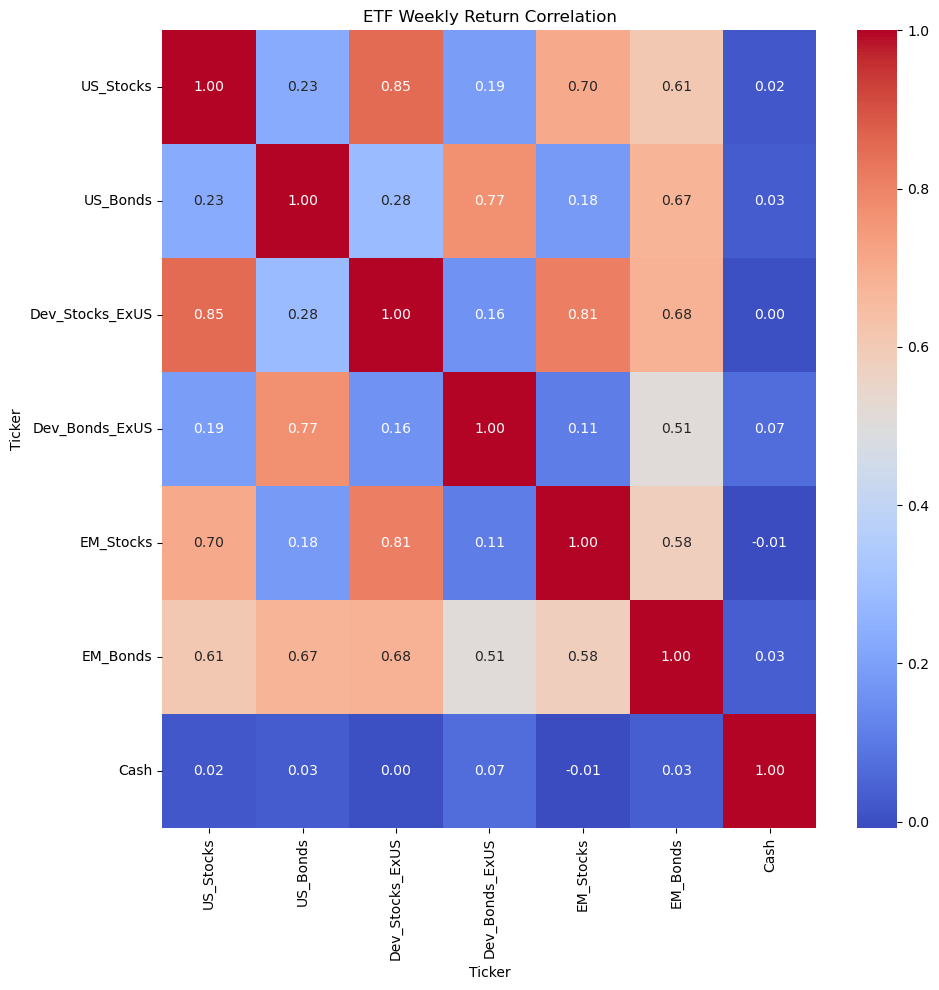

In [6]:
plt.figure(figsize=(10, 10))
sns.heatmap(simple_returns.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("ETF Weekly Return Correlation")
plt.tight_layout()
plt.show()

### Correlation Heatmap: Interpretation & Portfolio Insights

---

#### **What the Heatmap Shows**

- The heatmap visualizes the **pairwise correlations** between weekly returns of all ETFs in the portfolio.
- **Color intensity** indicates the strength and direction of correlation:
    - **Dark red:** Strong positive correlation (move together)
    - **Dark blue:** Strong negative correlation (move oppositely)
    - **White/light colors:** Weak or no correlation

---

#### **How to Interpret the Heatmap**

- **High Positive Correlation (close to +1):**
    - Assets tend to move in the same direction.
    - Example: US stocks and developed market stocks may show high correlation.
- **High Negative Correlation (close to -1):**
    - Assets move in opposite directions.
    - Example: Bonds and stocks sometimes exhibit negative or low correlation, especially during market stress.
- **Low/Zero Correlation (close to 0):**
    - Asset returns are largely independent.
    - Indicates potential for diversification.

---

#### **Portfolio Construction Insights**

- **Diversification Benefits:**
    - Combining assets with **low or negative correlations** reduces overall portfolio volatility.
    - Diversified portfolios are less sensitive to the performance of any single asset class.
- **Risk Reduction:**
    - Including assets that do not move together (e.g., stocks and bonds, or stocks and gold) can help cushion losses during market downturns.
- **Asset Allocation:**
    - Avoid over-allocating to highly correlated assets, as this can increase risk without improving returns.
    - Seek a mix of assets with complementary risk/return profiles.
- **Optimization Foundation:**
    - The correlation matrix is a key input for portfolio optimization, directly impacting the calculation of portfolio risk.

---

**In summary:**  
The heatmap helps identify which asset pairs offer the greatest diversification benefits. By selecting and weighting assets with lower correlations, you can construct a more resilient and efficient portfolio.

In [7]:
# Downside and tail risk analysis for each asset class

# 1. Value at Risk (VaR) at 5% level
VaR_5 = simple_returns.quantile(0.05)

# 2. Conditional Value at Risk (CVaR) at 5% level
CVaR_5 = simple_returns[simple_returns.lt(VaR_5)].mean()

# 3. Maximum drawdown
def max_drawdown(series):
    cumulative = (1 + series).cumprod()
    peak = cumulative.cummax()
    drawdown = (cumulative - peak) / peak
    return drawdown.min()

max_dd = simple_returns.apply(max_drawdown)

# 4. Beta vs. US Stocks
us_stock_returns = simple_returns['US_Stocks']
betas = {}
for asset in assets:
    if asset == 'US_Stocks':
        betas[asset] = 1.0
    else:
        cov = simple_returns[asset].cov(us_stock_returns)
        var = us_stock_returns.var()
        betas[asset] = cov / var

betas = pd.Series(betas)

# Compile results
risk_stats = pd.DataFrame({
    'VaR (5%)': VaR_5,
    'CVaR (5%)': CVaR_5,
    'Max Drawdown': max_dd,
    'Beta (vs US_Stocks)': betas
})

try:
    garch_vols = {}
    for asset in assets:
        am = arch_model(simple_returns[asset]*100, vol='Garch', p=1, q=1, rescale=False)
        res = am.fit(disp='off')
        garch_vols[asset] = res.conditional_volatility.mean() / 100  # Convert back to original scale
    risk_stats['Avg GARCH Vol'] = pd.Series(garch_vols)
except ImportError:
    print("arch package not installed. Skipping GARCH volatility modeling.")

print("Downside and Tail Risk Statistics:")
display(risk_stats.round(4))

# Select relevant columns for visualization
risk_plot = risk_stats[['VaR (5%)', 'CVaR (5%)', 'Max Drawdown', 'Avg GARCH Vol']]

# Prepare data for plotly
bar_traces = []
for metric in risk_plot.columns:
    bar_traces.append(
        go.Bar(
            x=risk_plot.index,
            y=risk_plot[metric],
            name=metric
        )
    )

fig = go.Figure(data=bar_traces)
fig.update_layout(
    barmode='group',
    title='Downside and Tail Risk Metrics by Asset Class (Interactive)',
    xaxis_title='Asset Class',
    yaxis_title='Value',
    legend_title='Metric',
    template='plotly_white',
    width=1000,
    height=600
)
pyo.iplot(fig)

Downside and Tail Risk Statistics:


,VaR (5%),CVaR (5%),Max Drawdown,Beta (vs US_Stocks),Avg GARCH Vol
US_Stocks,-0.0342,-0.0580,-0.3208,1.0000,0.0228
US_Bonds,-0.0113,-0.0165,-0.2305,0.0683,0.0067
Dev_Stocks_ExUS,-0.0354,-0.0556,-0.3758,0.8446,0.0225
Dev_Bonds_ExUS,-0.0098,-0.0168,-0.2038,0.0485,0.0060
EM_Stocks,-0.0415,-0.0586,-0.3896,0.7555,0.0251
EM_Bonds,-0.0191,-0.0335,-0.3379,0.3486,0.0127
Cash,-0.0025,-0.0031,-0.0056,0.0006,0.0007


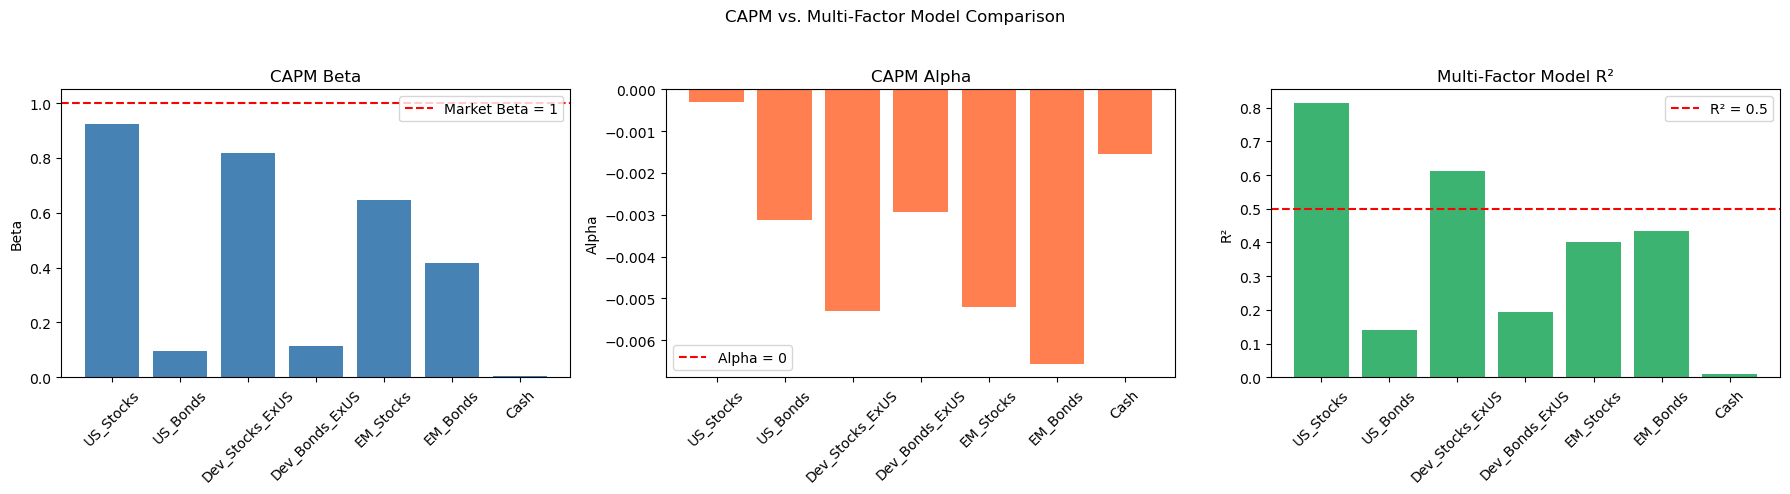

In [9]:
# Calculate monthly returns from weekly data
monthly_returns = simple_returns.resample('ME').apply(lambda x: (1 + x).prod() - 1)
monthly_returns.index = monthly_returns.index.to_period('M').to_timestamp('M') - pd.offsets.MonthEnd(1) + pd.DateOffset(days=1)

# Download Fama-French factors and momentum data
# Load local CSVs from Kenneth French (already downloaded and cleaned)
ff_factors = pd.read_csv('data/F-F_Research_Data_Factor.csv', skiprows=3)
momentum = pd.read_csv('data/F-F_Momentum_Factor.csv', skiprows=13)

# Clean and parse dates
ff_factors = ff_factors.rename(columns={ff_factors.columns[0]: 'Date'})
# Keep only rows where 'Date' is a 6-digit string (YYYYMM)
ff_factors = ff_factors[ff_factors['Date'].astype(str).str.match(r'^\d{6}$')]
ff_factors['Date'] = pd.to_datetime(ff_factors['Date'], format='%Y%m')
# Set datetime as index and convert values to decimal
ff_factors.set_index('Date', inplace=True)
ff_factors = ff_factors.astype(float) / 100

# Optional: Rename for compatibility
ff_factors.columns = ['Mkt_RF', 'SMB', 'HML', 'RF']

momentum = momentum.rename(columns={momentum.columns[0]: 'Date'})
# Keep only rows where 'Date' is a 6-digit string (YYYYMM)
momentum = momentum[momentum['Date'].astype(str).str.match(r'^\d{6}$')]
momentum['Date'] = pd.to_datetime(momentum['Date'], format='%Y%m')
momentum.set_index('Date', inplace=True)
momentum = momentum.astype(float) / 100
momentum = momentum.rename(columns={momentum.columns[0]: 'Mom'})

# Merge with Fama-French data
ff_factors = ff_factors.join(momentum)
ff_factors.columns = ['Mkt_RF', 'SMB', 'HML', 'RF', 'Mom']

# Align dates with your monthly returns
common_end = min(monthly_returns.index.max(), ff_factors.index.max())
ff_factors_aligned = ff_factors.loc[monthly_returns.index.min():common_end]
monthly_returns_aligned = monthly_returns.loc[monthly_returns.index.min():common_end]

# Perform CAPM and Multi-Factor Model regressions
regression_results = {}
capm_betas, capm_alphas, mfc_r2 = [], [], []

for asset in monthly_returns.columns:
    df = pd.concat([monthly_returns[asset], ff_factors_aligned], axis=1).dropna()
    df.columns = ['Ret', 'Mkt_RF', 'SMB', 'HML', 'RF', 'Mom']

    if df.empty:
        print(f"⚠️ Skipping {asset}: no overlapping data.")
        continue

    y = df['Ret'] - df['RF']

    X_capm = sm.add_constant(df['Mkt_RF'])
    capm_model = sm.OLS(y, X_capm).fit()

    X_mfc = sm.add_constant(df[['Mkt_RF', 'SMB', 'HML']])
    mfc_model = sm.OLS(y, X_mfc).fit()

    regression_results[asset] = {'CAPM': capm_model, 'MFC': mfc_model}
    capm_betas.append(capm_model.params['Mkt_RF'])
    capm_alphas.append(capm_model.params['const'])
    mfc_r2.append(mfc_model.rsquared)

regression_assets = monthly_returns.columns.tolist()
fig, ax = plt.subplots(1, 3, figsize=(18, 5))

ax[0].bar(regression_assets, capm_betas, color='steelblue')
ax[0].set_title('CAPM Beta')
ax[0].set_ylabel('Beta')
ax[0].tick_params(axis='x', rotation=45)
ax[0].axhline(1, color='red', linestyle='--', label='Market Beta = 1')
ax[0].legend()

ax[1].bar(regression_assets, capm_alphas, color='coral')
ax[1].set_title('CAPM Alpha')
ax[1].set_ylabel('Alpha')
ax[1].tick_params(axis='x', rotation=45)
ax[1].axhline(0, color='red', linestyle='--', label='Alpha = 0')
ax[1].legend()

ax[2].bar(regression_assets, mfc_r2, color='mediumseagreen')
ax[2].set_title('Multi-Factor Model R²')
ax[2].set_ylabel('R²')
ax[2].tick_params(axis='x', rotation=45)
ax[2].axhline(0.5, color='red', linestyle='--', label='R² = 0.5')
ax[2].legend()

plt.suptitle("CAPM vs. Multi-Factor Model Comparison")
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

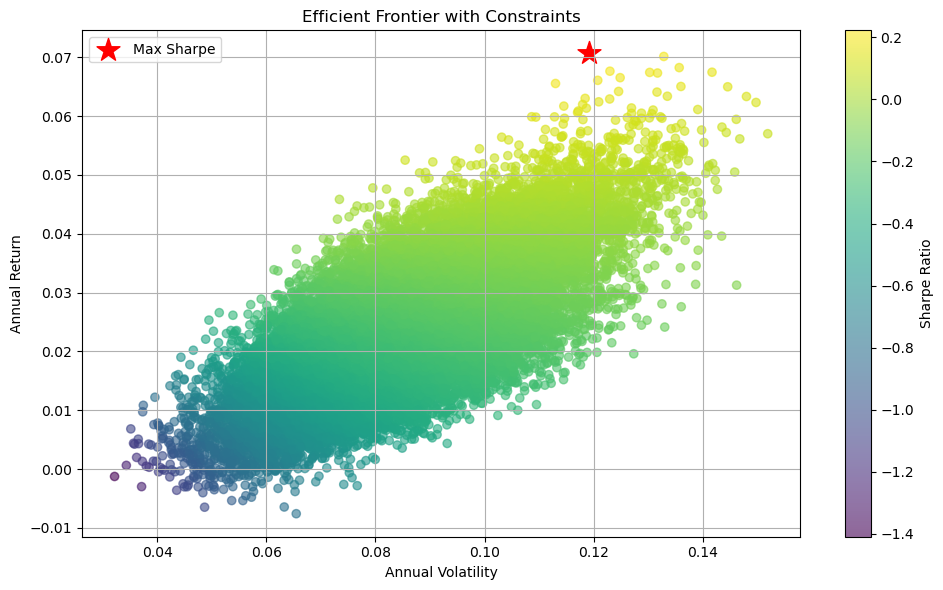

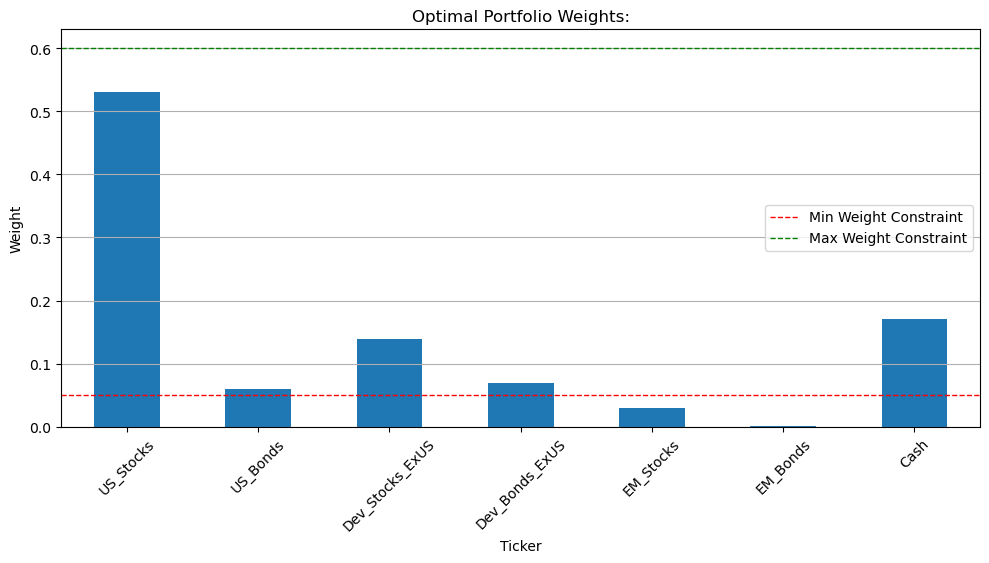

Optimal Portfolio Allocation (with Constraints):
            Ticker  Weight
0        US_Stocks  0.5312
1         US_Bonds  0.0596
2  Dev_Stocks_ExUS  0.1398
3   Dev_Bonds_ExUS  0.0694
4        EM_Stocks  0.0294
5         EM_Bonds  0.0005
6             Cash  0.1703
Expected Annual Return: 0.0707
Expected Annual Volatility: 0.1192
Max Sharpe Ratio: 0.2228
Optimal portfolio saved as 'optimal_portfolio_with_constraints.csv' in exports directory.


In [10]:
returns = data.pct_change().dropna()
mean_returns = returns.mean() * 52
cov_matrix = returns.cov() * 52

# Portfolio simulation with constraints
num_portfolios = 30000
results = np.zeros((3, num_portfolios))
weights_record = []

for i in range(num_portfolios):
    while True:
        weights = np.random.random(len(assets))
        weights /= np.sum(weights)

        # Enforce min/max constraints
        valid = True
        for j, asset in enumerate(assets):
            if asset in constraints:
                rule = constraints[asset]
                if rule['type'] == 'max' and weights[j] > rule['value']:
                    valid = False
                    break
                elif rule['type'] == 'min' and weights[j] < rule['value']:
                    valid = False
                    break
        if valid:
            break

    port_return = np.sum(mean_returns * weights)
    port_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    sharpe = (port_return - risk_free_rate) / port_volatility

    results[0, i] = port_return
    results[1, i] = port_volatility
    results[2, i] = sharpe
    weights_record.append(weights)

# Find portfolio with max Sharpe ratio
max_sharpe_idx = np.argmax(results[2])
optimal_weights = weights_record[max_sharpe_idx]
optimal_portfolio = pd.Series(optimal_weights, index=assets)
opt_port = optimal_portfolio.reset_index()
opt_port.columns = ['Ticker', 'Weight']


# Calculate optimal portfolio metrics
optimal_volatility = results[1, max_sharpe_idx]
optimal_return = results[0, max_sharpe_idx]
max_sharpe = results[2, max_sharpe_idx]

# Plot efficient frontier
plt.figure(figsize=(10, 6))
plt.scatter(results[1, :], results[0, :], c=results[2, :], cmap='viridis', alpha=0.6)
plt.colorbar(label='Sharpe Ratio')
plt.scatter(results[1, max_sharpe_idx], results[0, max_sharpe_idx], c='red', marker='*', s=300, label='Max Sharpe')
plt.title("Efficient Frontier with Constraints")
plt.xlabel("Annual Volatility")
plt.ylabel("Annual Return")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

optimal_portfolio.plot(kind='bar', title="Optimal Portfolio Weights:", figsize=(10, 6))
plt.ylabel("Weight")
plt.grid(axis='y')
plt.tight_layout()
plt.xticks(rotation=45)
plt.axhline(y=0.05, color='red', linewidth=1, linestyle='--', label='Min Weight Constraint')
plt.axhline(y=0.6, color='green', linewidth=1, linestyle='--', label='Max Weight Constraint')
plt.legend()
plt.show()

# Print optimal allocation
print("Optimal Portfolio Allocation (with Constraints):")
print(opt_port.round(4))
print(f"Expected Annual Return: {optimal_return:.4f}")
print(f"Expected Annual Volatility: {optimal_volatility:.4f}")  
print(f"Max Sharpe Ratio: {max_sharpe:.4f}")
# Save optimal portfolio to CSV

opt_port.to_csv("exports/optimal_portfolio_with_constraints.csv")
print("Optimal portfolio saved as 'optimal_portfolio_with_constraints.csv' in exports directory.")

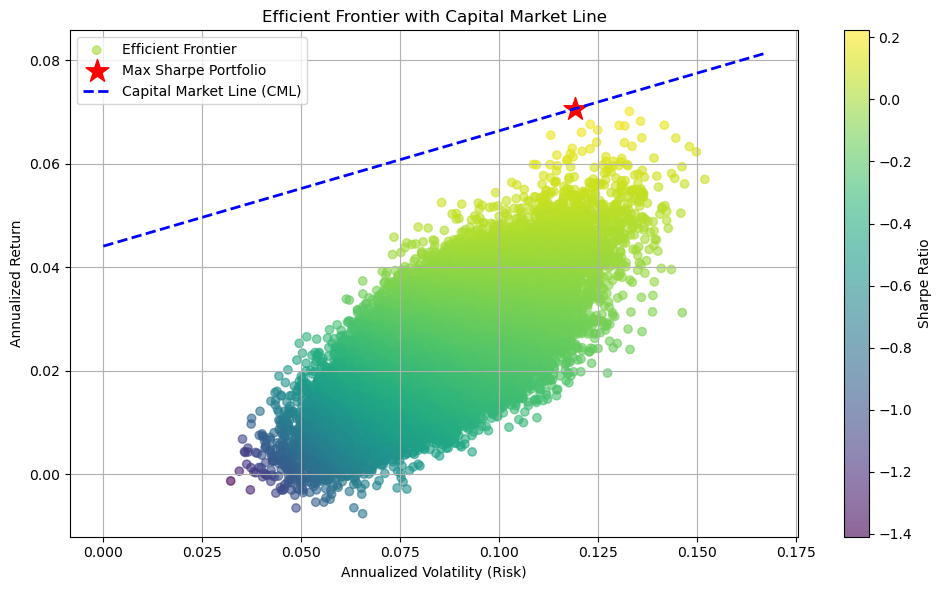

In [11]:
# Define x-axis range: from 0 to a bit beyond the optimal volatility
x = np.linspace(0, max(results[1]) * 1.1, 100)

# CML equation: R = Rf + Sharpe * σ
cml = risk_free_rate + max_sharpe * x

# Plot Efficient Frontier
plt.figure(figsize=(10, 6))
plt.scatter(results[1], results[0], c=results[2], cmap='viridis', alpha=0.6, label='Efficient Frontier')
plt.colorbar(label='Sharpe Ratio')

# Highlight optimal portfolio
plt.scatter(optimal_volatility, optimal_return, c='red', marker='*', s=300, label='Max Sharpe Portfolio')

# Plot Capital Market Line
plt.plot(x, cml, color='blue', linestyle='--', linewidth=2, label='Capital Market Line (CML)')

# Labels and layout
plt.title("Efficient Frontier with Capital Market Line")
plt.xlabel("Annualized Volatility (Risk)")
plt.ylabel("Annualized Return")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [12]:
min_var_idx = np.argmin(results[1])  # lowest volatility
min_var_vol = results[1][min_var_idx]
min_var_ret = results[0][min_var_idx]
min_var_sharpe = results[2][min_var_idx]
min_var_weights = weights_record[min_var_idx]
min_var_portfolio = pd.Series(min_var_weights, index=assets)
print(min_var_portfolio.round(4))
print(f"Minimum Volatility Portfolio")
print(f"Expected Annual Return: {min_var_ret:.4f}")
print(f"Expected Annual Volatility: {min_var_vol:.4f}")
print(f"Max Sharpe Ratio: {min_var_sharpe:.4f}")

Ticker
US_Stocks          0.0073
US_Bonds           0.1882
Dev_Stocks_ExUS    0.0016
Dev_Bonds_ExUS     0.3345
EM_Stocks          0.0507
EM_Bonds           0.0615
Cash               0.3561
dtype: float64
Minimum Volatility Portfolio
Expected Annual Return: -0.0012
Expected Annual Volatility: 0.0322
Max Sharpe Ratio: -1.4095


In [13]:
# Identify indices of Max Sharpe and Min Variance portfolios
#    results[0, i] = port_return
#    results[1, i] = port_volatility
#    results[2, i] = sharpe

sharpe_ratios = results[2]
portfolio_returns = results[0]
portfolio_vols = results[1]

max_sharpe_idx = np.argmax(sharpe_ratios)
min_var_idx = np.argmin(portfolio_vols)

# Extract weights
max_sharpe_weights = weights_record[max_sharpe_idx]
min_var_weights = weights_record[min_var_idx]

# Extract stats
max_sharpe_return = portfolio_returns[max_sharpe_idx]
max_sharpe_vol = portfolio_vols[max_sharpe_idx]
max_sharpe_ratio = sharpe_ratios[max_sharpe_idx]

min_var_return = portfolio_returns[min_var_idx]
min_var_vol = portfolio_vols[min_var_idx]
min_var_ratio = sharpe_ratios[min_var_idx]

mvp_df = pd.DataFrame({
    "Asset": list(tickers.keys()),
    "Weight": min_var_weights
}).set_index("Asset")
mvp_df.loc["Total"] = mvp_df.sum()

tangency_df = pd.DataFrame({
    "Asset": list(tickers.keys()),
    "Weight": max_sharpe_weights
}).set_index("Asset")
tangency_df.loc["Total"] = tangency_df.sum()

# Display weights and summary stats
print("📉 Minimum Variance Portfolio:")
print(mvp_df.round(4))
print(f"Return: {min_var_return:.4%} | Volatility: {min_var_vol:.4%} | Sharpe Ratio: {min_var_ratio:.2f}")
print("\n⭐ Maximum Sharpe Portfolio:")
print(tangency_df.round(4))
print(f"Return: {max_sharpe_return:.4%} | Volatility: {max_sharpe_vol:.4%} | Sharpe Ratio: {max_sharpe_ratio:.2f}")

📉 Minimum Variance Portfolio:
                 Weight
Asset                  
US_Stocks        0.0073
US_Bonds         0.1882
Dev_Stocks_ExUS  0.0016
Dev_Bonds_ExUS   0.3345
EM_Stocks        0.0507
EM_Bonds         0.0615
Cash             0.3561
Total            1.0000
Return: -0.1248% | Volatility: 3.2172% | Sharpe Ratio: -1.41

⭐ Maximum Sharpe Portfolio:
                 Weight
Asset                  
US_Stocks        0.5312
US_Bonds         0.0596
Dev_Stocks_ExUS  0.1398
Dev_Bonds_ExUS   0.0694
EM_Stocks        0.0294
EM_Bonds         0.0005
Cash             0.1703
Total            1.0000
Return: 7.0654% | Volatility: 11.9179% | Sharpe Ratio: 0.22
